In [1]:
# https://medium.com/@HeeebsInc/using-machine-learning-to-predict-daily-fantasy-basketball-scores-part-i-811de3c54a98

# https://medium.com/fun-with-data-and-stats/drafting-a-fantasy-basketball-team-c94967464908

# Web Scraper

In [1]:
# https://github.com/klaudius1D/ShootersShoot/tree/main

In [2]:
import pandas as pd
import requests
import os
from bs4 import BeautifulSoup

# settings
pd.set_option('display.max_columns', None)

In [3]:
# Set Playoff Years from 2020 to 2023
years = list(range(2016, 2025))

# {} used to vary dates in loop
url_start = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html"

# Replace brackets with specific years based on list
for year in years:
    url = url_start.format(year)
    data = requests.get(url)

    # Create HTML files for each year
    with open("topPicksHTML/Playoffs-{}_topPicks.html".format(year), "wb") as f:
        f.write(data.content)

In [4]:
# using a loop, parse each html for each year in years list
dfs = []
for year in years:
    url = url_start.format(year)
    data = requests.get(url)
    soup = BeautifulSoup(data.content, "html.parser")
    topPicks_table = soup.find("table", {"id": "per_game_stats"})
    topPicks_df = pd.read_html(str(topPicks_table))[0]
    topPicks_df = topPicks_df[topPicks_df.Rk != "Rk"]
    topPicks_df["Year"] = year

    dfs.append(topPicks_df)

    # Save all contents into one csv files into new folder called topPicksCSV
    topPicks_df.to_csv("topPicksCSV/Playoffs-{}_topPicks.csv".format(year), index=False)

In [5]:
# combine all dataframes into one
df = pd.concat(dfs)
df.to_csv("topPicksCSV/Playoffs-Master_topPicks.csv", index=False)

In [6]:
# check contents of dataframe, ensure all years are included
df.head()
df.tail()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
506,472,Thaddeus Young,PF,35,TOR,3,0,3.3,0.7,1.3,.500,0.0,0.0,NaN,0.7,1.3,.500,.500,0.0,0.7,.000,0.3,0.7,1.0,1.0,0.0,0.0,0.3,0.0,1.3,2024
507,473,Trae Young,PG,25,ATL,11,11,35.7,6.3,17.6,.356,2.0,7.1,.282,4.3,10.5,.405,.412,8.8,9.8,.898,0.6,2.0,2.6,11.1,1.5,0.0,4.1,1.5,23.4,2024
508,474,Omer Yurtseven,C,25,UTA,7,0,4.6,1.0,1.4,.700,0.1,0.4,.333,0.9,1.0,.857,.750,0.1,0.3,.500,0.4,1.1,1.6,0.4,0.0,0.1,0.1,0.9,2.3,2024
509,475,Cody Zeller,C,31,NOP,11,0,8.3,0.6,1.9,.333,0.0,0.1,.000,0.6,1.8,.350,.333,0.5,1.3,.357,1.2,2.2,3.4,0.9,0.2,0.1,0.4,0.9,1.7,2024
510,476,Ivica Zubac,C,26,LAC,12,12,25.7,4.2,7.1,.588,0.0,0.0,NaN,4.2,7.1,.588,.588,1.9,3.1,.622,2.9,5.6,8.5,0.8,0.2,1.6,1.3,2.9,10.3,2024


# Testing

In [7]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Quincy Acy,PF,25,SAC,59,29,14.8,2.0,3.6,.556,0.3,0.8,.388,1.7,2.8,.606,.600,0.8,1.2,.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016
1,2,Jordan Adams,SG,21,MEM,2,0,7.5,1.0,3.0,.333,0.0,0.5,.000,1.0,2.5,.400,.333,1.5,2.5,.600,0.0,1.0,1.0,1.5,1.5,0.0,1.0,1.0,3.5,2016
2,3,Steven Adams,C,22,OKC,80,80,25.2,3.3,5.3,.613,0.0,0.0,NaN,3.3,5.3,.613,.613,1.4,2.5,.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,2016
3,4,Arron Afflalo,SG,30,NYK,71,57,33.4,5.0,11.3,.443,1.3,3.4,.382,3.7,7.9,.469,.500,1.5,1.8,.840,0.3,3.4,3.7,2.0,0.4,0.1,1.2,2.0,12.8,2016
4,5,Alexis Ajinça,C,27,NOP,59,17,14.6,2.5,5.3,.476,0.0,0.0,.000,2.5,5.3,.478,.476,0.9,1.1,.839,1.3,3.3,4.6,0.5,0.3,0.6,0.9,2.3,6.0,2016


In [8]:
df.info()

# NEED TO CONVERT THESE COLUMNS TO INT

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5877 entries, 0 to 507
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rk      5877 non-null   object
 1   Player  5877 non-null   object
 2   Pos     5877 non-null   object
 3   Age     5877 non-null   object
 4   Tm      5877 non-null   object
 5   G       5877 non-null   object
 6   GS      5877 non-null   object
 7   MP      5877 non-null   object
 8   FG      5877 non-null   object
 9   FGA     5877 non-null   object
 10  FG%     5827 non-null   object
 11  3P      5877 non-null   object
 12  3PA     5877 non-null   object
 13  3P%     5435 non-null   object
 14  2P      5877 non-null   object
 15  2PA     5877 non-null   object
 16  2P%     5759 non-null   object
 17  eFG%    5827 non-null   object
 18  FT      5877 non-null   object
 19  FTA     5877 non-null   object
 20  FT%     5452 non-null   object
 21  ORB     5877 non-null   object
 22  DRB     5877 non-null   o

In [9]:
for column in df.columns:
    try:
        df[column] = pd.to_numeric(df[column], errors='raise').fillna(0).astype(float)
    except (ValueError, TypeError):
        pass  # Ignore columns that cannot be converted

In [10]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Quincy Acy,PF,25.0,SAC,59.0,29.0,14.8,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016.0
1,2.0,Jordan Adams,SG,21.0,MEM,2.0,0.0,7.5,1.0,3.0,0.333,0.0,0.5,0.000,1.0,2.5,0.400,0.333,1.5,2.5,0.600,0.0,1.0,1.0,1.5,1.5,0.0,1.0,1.0,3.5,2016.0
2,3.0,Steven Adams,C,22.0,OKC,80.0,80.0,25.2,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.613,0.613,1.4,2.5,0.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,2016.0
3,4.0,Arron Afflalo,SG,30.0,NYK,71.0,57.0,33.4,5.0,11.3,0.443,1.3,3.4,0.382,3.7,7.9,0.469,0.500,1.5,1.8,0.840,0.3,3.4,3.7,2.0,0.4,0.1,1.2,2.0,12.8,2016.0
4,5.0,Alexis Ajinça,C,27.0,NOP,59.0,17.0,14.6,2.5,5.3,0.476,0.0,0.0,0.000,2.5,5.3,0.478,0.476,0.9,1.1,0.839,1.3,3.3,4.6,0.5,0.3,0.6,0.9,2.3,6.0,2016.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5877 entries, 0 to 507
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      5877 non-null   float64
 1   Player  5877 non-null   object 
 2   Pos     5877 non-null   object 
 3   Age     5877 non-null   float64
 4   Tm      5877 non-null   object 
 5   G       5877 non-null   float64
 6   GS      5877 non-null   float64
 7   MP      5877 non-null   float64
 8   FG      5877 non-null   float64
 9   FGA     5877 non-null   float64
 10  FG%     5877 non-null   float64
 11  3P      5877 non-null   float64
 12  3PA     5877 non-null   float64
 13  3P%     5877 non-null   float64
 14  2P      5877 non-null   float64
 15  2PA     5877 non-null   float64
 16  2P%     5877 non-null   float64
 17  eFG%    5877 non-null   float64
 18  FT      5877 non-null   float64
 19  FTA     5877 non-null   float64
 20  FT%     5877 non-null   float64
 21  ORB     5877 non-null   float64
 22  D

# Clean for Fantasy

In [12]:
clean_fantasy = [
    "Player", 
    "MP", 
    "FG%",
    "FT%",
    "3P",
    "PTS",
    "TRB", 
    "AST",
    "STL",
    "BLK",
    "TOV",

]

In [13]:
per_30_stats = df[clean_fantasy]

In [14]:
per_30_stats[["PTS", "TRB", "AST", "STL", "BLK", "TOV"]] = df[["PTS", "TRB", "AST", "STL", "BLK", "TOV"]].div(df['MP'], axis = 0).multiply(30)

C:\Users\nehcr\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [15]:
per_30_stats.head()

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
0,Quincy Acy,14.8,0.556,0.735,0.3,10.540541,6.486486,1.013514,1.013514,0.810811,1.013514
1,Jordan Adams,7.5,0.333,0.600,0.0,14.000000,4.000000,6.000000,6.000000,0.000000,4.000000
2,Steven Adams,25.2,0.613,0.582,0.0,9.523810,7.976190,0.952381,0.595238,1.309524,1.309524
3,Arron Afflalo,33.4,0.443,0.840,1.3,11.497006,3.323353,1.796407,0.359281,0.089820,1.077844
4,Alexis Ajinça,14.6,0.476,0.839,0.0,12.328767,9.452055,1.027397,0.616438,1.232877,1.849315


In [16]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Quincy Acy,PF,25.0,SAC,59.0,29.0,14.8,2.0,3.6,0.556,0.3,0.8,0.388,1.7,2.8,0.606,0.600,0.8,1.2,0.735,1.1,2.1,3.2,0.5,0.5,0.4,0.5,1.7,5.2,2016.0
1,2.0,Jordan Adams,SG,21.0,MEM,2.0,0.0,7.5,1.0,3.0,0.333,0.0,0.5,0.000,1.0,2.5,0.400,0.333,1.5,2.5,0.600,0.0,1.0,1.0,1.5,1.5,0.0,1.0,1.0,3.5,2016.0
2,3.0,Steven Adams,C,22.0,OKC,80.0,80.0,25.2,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.613,0.613,1.4,2.5,0.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,2016.0
3,4.0,Arron Afflalo,SG,30.0,NYK,71.0,57.0,33.4,5.0,11.3,0.443,1.3,3.4,0.382,3.7,7.9,0.469,0.500,1.5,1.8,0.840,0.3,3.4,3.7,2.0,0.4,0.1,1.2,2.0,12.8,2016.0
4,5.0,Alexis Ajinça,C,27.0,NOP,59.0,17.0,14.6,2.5,5.3,0.476,0.0,0.0,0.000,2.5,5.3,0.478,0.476,0.9,1.1,0.839,1.3,3.3,4.6,0.5,0.3,0.6,0.9,2.3,6.0,2016.0


In [17]:
df['Year'].value_counts()

2022.0    812
2019.0    708
2021.0    705
2023.0    679
2018.0    664
2020.0    651
2017.0    595
2016.0    578
2024.0    485
Name: Year, dtype: int64

In [18]:
df['Year'].value_counts().keys()

Float64Index([2022.0, 2019.0, 2021.0, 2023.0, 2018.0, 2020.0, 2017.0, 2016.0,
              2024.0],
             dtype='float64')

In [19]:
df[df['Year'] == 2021.0]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1.0,Precious Achiuwa,PF,21.0,MIA,61.0,4.0,12.1,2.0,3.7,0.544,0.0,0.0,0.000,2.0,3.7,0.546,0.544,0.9,1.8,0.509,1.2,2.2,3.4,0.5,0.3,0.5,0.7,1.5,5.0,2021.0
1,2.0,Jaylen Adams,PG,24.0,MIL,7.0,0.0,2.6,0.1,1.1,0.125,0.0,0.3,0.000,0.1,0.9,0.167,0.125,0.0,0.0,0.000,0.0,0.4,0.4,0.3,0.0,0.0,0.0,0.1,0.3,2021.0
2,3.0,Steven Adams,C,27.0,NOP,58.0,58.0,27.7,3.3,5.3,0.614,0.0,0.1,0.000,3.3,5.3,0.620,0.614,1.0,2.3,0.444,3.7,5.2,8.9,1.9,0.9,0.7,1.3,1.9,7.6,2021.0
3,4.0,Bam Adebayo,C,23.0,MIA,64.0,64.0,33.5,7.1,12.5,0.570,0.0,0.1,0.250,7.1,12.4,0.573,0.571,4.4,5.5,0.799,2.2,6.7,9.0,5.4,1.2,1.0,2.6,2.3,18.7,2021.0
4,5.0,LaMarcus Aldridge,C,35.0,TOT,26.0,23.0,25.9,5.4,11.4,0.473,1.2,3.1,0.388,4.2,8.3,0.505,0.525,1.6,1.8,0.872,0.7,3.8,4.5,1.9,0.4,1.1,1.0,1.8,13.5,2021.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,536.0,Delon Wright,PG,28.0,SAC,27.0,8.0,25.8,3.9,8.3,0.462,1.2,3.1,0.398,2.6,5.3,0.500,0.536,1.1,1.3,0.833,1.0,2.9,3.9,3.6,1.6,0.4,1.3,1.1,10.0,2021.0
727,537.0,Thaddeus Young,PF,32.0,CHI,68.0,23.0,24.3,5.4,9.7,0.559,0.2,0.7,0.267,5.3,9.1,0.580,0.568,1.0,1.7,0.628,2.5,3.8,6.2,4.3,1.1,0.6,2.0,2.2,12.1,2021.0
728,538.0,Trae Young,PG,22.0,ATL,63.0,63.0,33.7,7.7,17.7,0.438,2.2,6.3,0.343,5.6,11.3,0.491,0.499,7.7,8.7,0.886,0.6,3.3,3.9,9.4,0.8,0.2,4.1,1.8,25.3,2021.0
729,539.0,Cody Zeller,C,28.0,CHO,48.0,21.0,20.9,3.8,6.8,0.559,0.1,0.6,0.143,3.7,6.2,0.598,0.565,1.8,2.5,0.714,2.5,4.4,6.8,1.8,0.6,0.4,1.1,2.5,9.4,2021.0


In [20]:
# Initialize an empty dictionary to store subsets
year_subsets = {}

# Get unique years from the 'Year' column
unique_years = df['Year'].unique()

# Iterate through unique years and create subsets
for year in unique_years:
    year_subsets[year] = df[df['Year'] == year]

In [21]:
year_subsets[2023].describe()

,Rk,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
count,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.000000,679.0
mean,265.976436,26.025037,43.337261,20.069219,19.464212,3.249337,6.921060,0.462190,0.996613,2.783063,0.318141,2.254934,4.138439,0.527147,0.532948,1.366568,1.768630,0.711576,0.842268,2.620324,3.461708,2.011782,0.601767,0.370545,1.067305,1.660825,8.859057,2023.0
std,154.956296,4.325709,24.729145,25.766359,9.415320,2.362501,4.795565,0.116682,0.862033,2.209284,0.139918,1.906812,3.380376,0.147627,0.114166,1.478315,1.793762,0.224774,0.731867,1.715881,2.281077,1.891335,0.392063,0.367465,0.799478,0.770299,6.630944,0.0
min,1.000000,19.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2023.0
25%,132.500000,23.000000,22.000000,0.000000,12.150000,1.500000,3.400000,0.415000,0.300000,1.000000,0.286000,0.900000,1.700000,0.484000,0.496000,0.400000,0.600000,0.667000,0.300000,1.400000,1.800000,0.800000,0.300000,0.100000,0.500000,1.200000,4.100000,2023.0
50%,264.000000,25.000000,45.000000,6.000000,18.800000,2.600000,5.700000,0.454000,0.800000,2.400000,0.346000,1.600000,3.100000,0.535000,0.537000,0.900000,1.200000,0.760000,0.700000,2.300000,3.000000,1.300000,0.500000,0.300000,0.900000,1.600000,6.900000,2023.0
75%,399.500000,29.000000,65.500000,36.500000,27.550000,4.200000,9.200000,0.505000,1.500000,4.150000,0.388000,3.000000,5.550000,0.594000,0.579000,1.700000,2.300000,0.841000,1.100000,3.400000,4.500000,2.700000,0.800000,0.500000,1.400000,2.200000,11.550000,2023.0
max,539.000000,42.000000,83.000000,83.000000,41.000000,11.200000,22.200000,1.000000,4.900000,11.400000,1.000000,10.500000,17.800000,1.000000,1.000000,10.000000,12.300000,1.000000,5.100000,9.600000,12.500000,10.700000,3.000000,3.000000,4.100000,5.000000,33.100000,2023.0


In [22]:
cleaned_2021 = year_subsets[2021][year_subsets[2021]["MP"] > 15][clean_fantasy]

In [23]:
cleaned_2021

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
2,Steven Adams,27.7,0.614,0.444,0.0,7.6,8.9,1.9,0.9,0.7,1.3
3,Bam Adebayo,33.5,0.570,0.799,0.0,18.7,9.0,5.4,1.2,1.0,2.6
4,LaMarcus Aldridge,25.9,0.473,0.872,1.2,13.5,4.5,1.9,0.4,1.1,1.0
5,LaMarcus Aldridge,25.9,0.464,0.838,1.3,13.7,4.5,1.7,0.4,0.9,1.0
6,LaMarcus Aldridge,26.0,0.521,1.000,0.8,12.8,4.8,2.6,0.6,2.2,1.4
...,...,...,...,...,...,...,...,...,...,...,...
726,Delon Wright,25.8,0.462,0.833,1.2,10.0,3.9,3.6,1.6,0.4,1.3
727,Thaddeus Young,24.3,0.559,0.628,0.2,12.1,6.2,4.3,1.1,0.6,2.0
728,Trae Young,33.7,0.438,0.886,2.2,25.3,3.9,9.4,0.8,0.2,4.1
729,Cody Zeller,20.9,0.559,0.714,0.1,9.4,6.8,1.8,0.6,0.4,1.1


In [24]:
cleaned_2023 = year_subsets[2023][year_subsets[2023]["MP"] > 15][clean_fantasy]

In [25]:
cleaned_2023

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
0,Precious Achiuwa,20.7,0.485,0.702,0.5,9.2,6.0,0.9,0.6,0.5,1.1
1,Steven Adams,27.0,0.597,0.364,0.0,8.6,11.5,2.3,0.9,1.1,1.9
2,Bam Adebayo,34.6,0.540,0.806,0.0,20.4,9.2,3.2,1.2,0.8,2.5
3,Ochai Agbaji,20.5,0.427,0.812,1.4,7.9,2.1,1.1,0.3,0.3,0.7
4,Santi Aldama,21.8,0.470,0.750,1.2,9.0,4.8,1.3,0.6,0.6,0.8
...,...,...,...,...,...,...,...,...,...,...,...
696,Christian Wood,25.9,0.515,0.772,1.6,16.6,7.3,1.8,0.4,1.1,1.8
697,Delon Wright,24.4,0.474,0.867,0.8,7.4,3.6,3.9,1.8,0.3,0.9
699,Gabe York,18.7,0.381,1.000,2.0,8.0,2.0,1.7,0.7,0.0,0.0
701,Trae Young,34.8,0.429,0.886,2.1,26.2,3.0,10.2,1.1,0.1,4.1


In [26]:
cleaned_2016 = year_subsets[2016][year_subsets[2016]["MP"] > 15][clean_fantasy]

In [27]:
cleaned_2016

,Player,MP,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV
2,Steven Adams,25.2,0.613,0.582,0.0,8.0,6.7,0.8,0.5,1.1,1.1
3,Arron Afflalo,33.4,0.443,0.840,1.3,12.8,3.7,2.0,0.4,0.1,1.2
6,LaMarcus Aldridge,30.6,0.513,0.858,0.0,18.0,8.5,1.5,0.5,1.1,1.3
8,Lavoy Allen,20.2,0.516,0.630,0.0,5.4,5.4,1.0,0.3,0.5,0.9
9,Tony Allen,25.3,0.458,0.652,0.2,8.4,4.6,1.1,1.7,0.3,1.2
...,...,...,...,...,...,...,...,...,...,...,...
592,Brandan Wright,17.7,0.673,0.542,0.0,6.9,3.6,0.5,0.4,1.3,0.8
594,Tony Wroten,18.0,0.338,0.541,0.4,8.4,2.6,2.5,0.4,0.0,3.6
597,Nick Young,19.1,0.339,0.829,1.4,7.3,1.8,0.6,0.4,0.1,0.6
598,Thaddeus Young,33.0,0.514,0.644,0.1,15.1,9.0,1.9,1.5,0.5,1.9


# Cleaning

In [28]:
clean_df = df[df['MP'] >= 15]

# Frequency Distributions

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

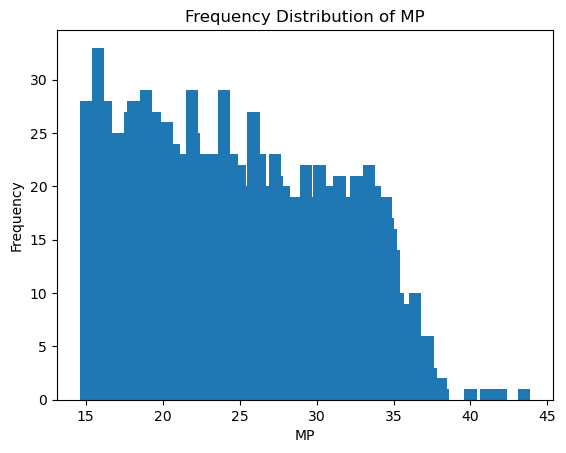

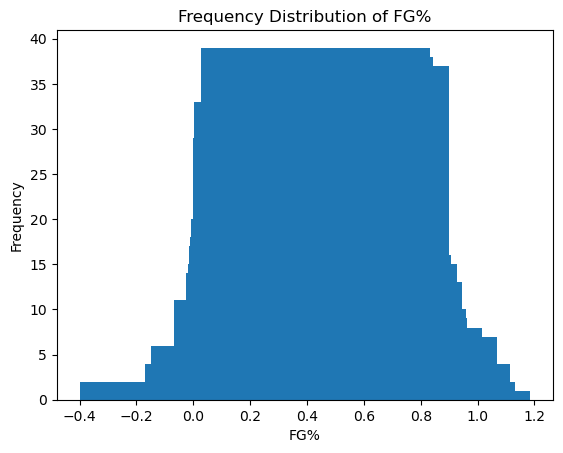

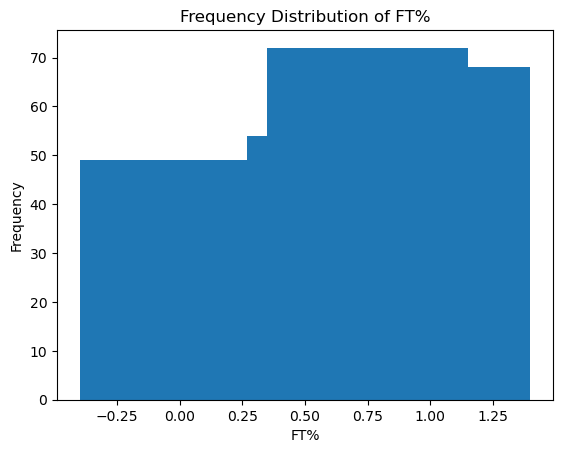

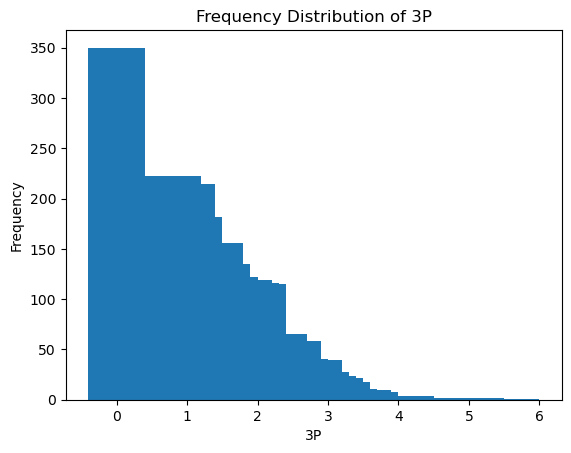

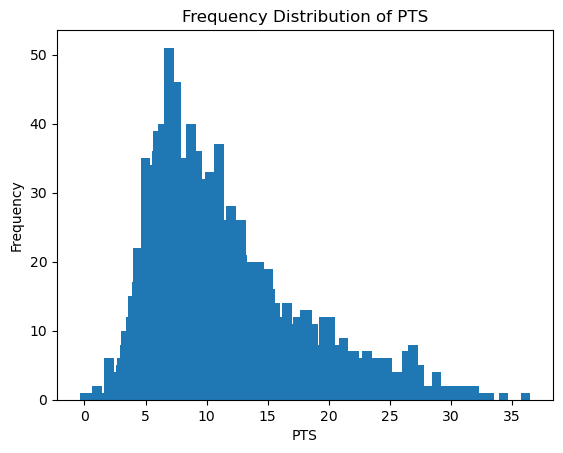

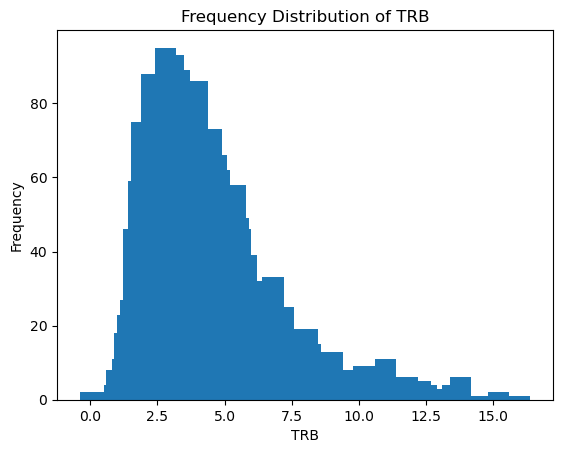

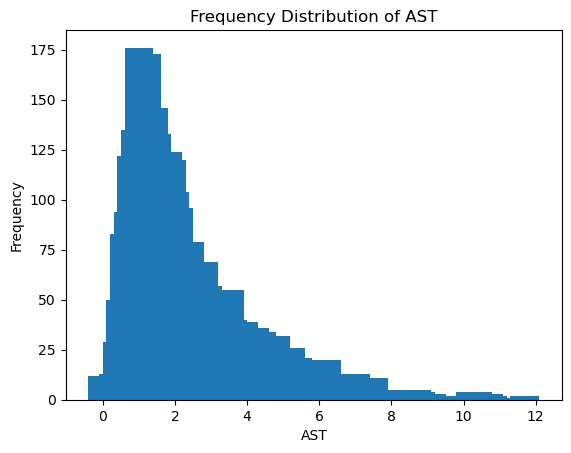

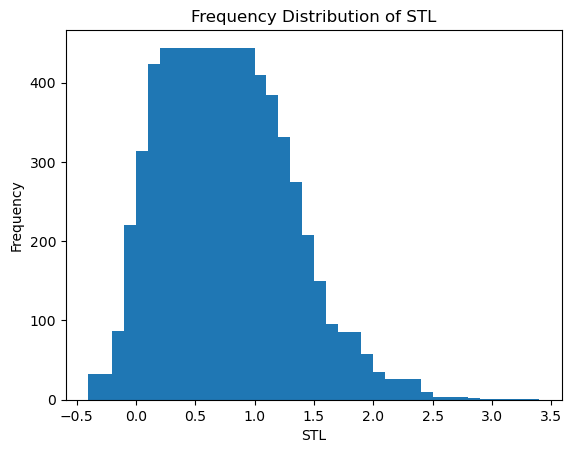

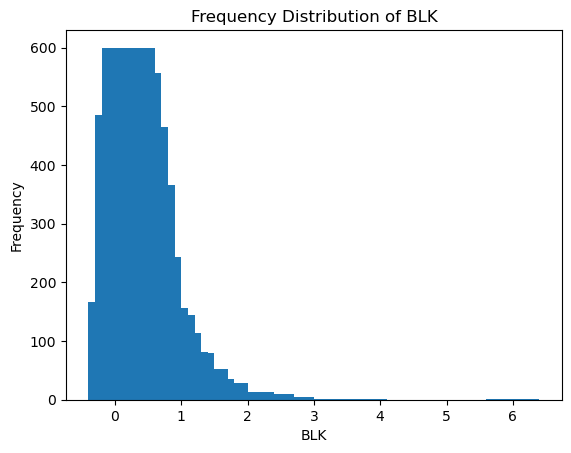

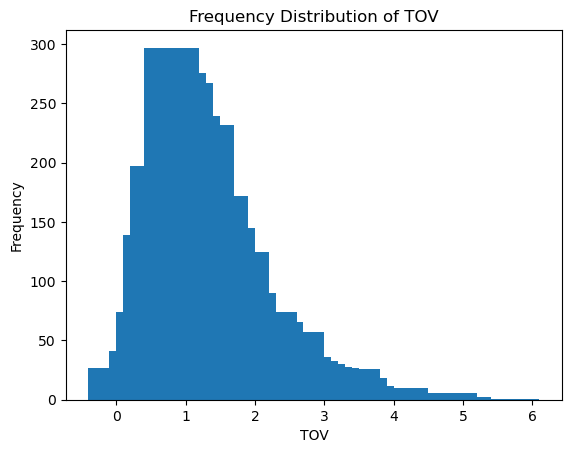

In [30]:
# List of column names to visualize
columns_to_visualize = ['MP', 'FG%', 'FT%', '3P', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV']

# Create and display frequency distribution plots for each column
for column in columns_to_visualize:
    freq = clean_df[column].value_counts().sort_index()

    plt.bar(freq.index, freq.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Frequency Distribution of {column}')
    plt.show()

# Correlation Analysis

### FG%

In [31]:
clean_df['Year'] = pd.to_numeric(clean_df['Year'], errors='coerce')
clean_df['FG%'] = pd.to_numeric(clean_df['FG%'], errors='coerce')

fg_correlation = clean_df.groupby('Year')['FG%'].corr(clean_df['Year'])
fg_correlation

C:\Users\nehcr\AppData\Local\Temp\ipykernel_6000\2297746267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Year'] = pd.to_numeric(clean_df['Year'], errors='coerce')
C:\Users\nehcr\AppData\Local\Temp\ipykernel_6000\2297746267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['FG%'] = pd.to_numeric(clean_df['FG%'], errors='coerce')


Year
2016.0    0.011780
2017.0    0.000157
2018.0   -0.010749
2019.0   -0.005762
2020.0   -0.008418
2021.0   -0.003343
2022.0    0.002127
2023.0    0.011844
2024.0   -0.009035
Name: FG%, dtype: float64

In [32]:
# need to spend some time reviewing pearson correlation coefficients to truly analyze this

# Improving Z Scores

https://github.com/zer2/Fantasy-Basketball--in-progress-

https://arxiv.org/pdf/2307.02188.pdf

### Basic Z Score calculation

##### Overall Fantasy Z Scores 2016 - 2024

In [33]:
fantasy_relevant_columns = ['Player', 'FG%', 'FT%', '3P', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV']

fantasy_df_clean = clean_df[fantasy_relevant_columns]

In [34]:
# Extract the player names (assuming 'Player' is a column in your dataset)
player_names = fantasy_df_clean['Player']

# Calculate the mean and standard deviation for each category
category_means = fantasy_df_clean.mean()
category_std = fantasy_df_clean.std()

# Calculate Z-scores for each player and category
z_score_calc = (fantasy_df_clean - category_means) / category_std

# Rename columns in the z_scores DataFrame to indicate they are Z-scores
z_score_calc.columns = [f'{col}_Z' for col in z_score_calc.columns]

# Combine the original values and Z-scores into a new DataFrame
fantasy_df_z = pd.concat([fantasy_df_clean, z_score_calc], axis=1)

In [35]:
fantasy_df_z

,Player,FG%,FT%,3P,PTS,TRB,AST,STL,BLK,TOV,3P_Z,AST_Z,BLK_Z,FG%_Z,FT%_Z,PTS_Z,Player_Z,STL_Z,TOV_Z,TRB_Z
2,Steven Adams,0.613,0.582,0.0,8.0,6.7,0.8,0.5,1.1,1.1,-1.398359,-0.927118,1.402068,2.075109,-1.248403,-0.563113,NaN,-0.745826,-0.369002,0.957571
3,Arron Afflalo,0.443,0.840,1.3,12.8,3.7,2.0,0.4,0.1,1.2,0.128574,-0.282805,-0.870406,-0.208902,0.611558,0.266786,NaN,-1.002085,-0.243655,-0.307792
6,LaMarcus Aldridge,0.513,0.858,0.0,18.0,8.5,1.5,0.5,1.1,1.3,-1.398359,-0.551269,1.402068,0.731573,0.741322,1.165843,NaN,-0.745826,-0.118308,1.716789
8,Lavoy Allen,0.516,0.630,0.0,5.4,5.4,1.0,0.3,0.5,0.9,-1.398359,-0.819732,0.038583,0.771879,-0.902364,-1.012641,NaN,-1.258345,-0.619695,0.409247
9,Tony Allen,0.458,0.652,0.2,8.4,4.6,1.1,1.7,0.3,1.2,-1.163446,-0.766040,-0.415911,-0.007371,-0.743763,-0.493954,NaN,2.329292,-0.243655,0.071817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,Zion Williamson,0.524,0.573,0.1,21.8,6.3,4.4,0.8,0.3,2.9,-1.280903,1.005819,-0.415911,0.879362,-1.313286,1.822847,NaN,0.022954,1.887238,0.788856
501,Christian Wood,0.427,0.615,0.8,6.5,6.1,0.8,0.2,0.6,1.3,-0.458708,-0.927118,0.265831,-0.423867,-1.010501,-0.822456,NaN,-1.514605,-0.118308,0.704499
502,Delon Wright,0.367,0.875,0.5,5.0,2.5,4.4,1.6,0.1,0.5,-0.811077,1.005819,-0.870406,-1.229989,0.863878,-1.081799,NaN,2.073032,-1.121082,-0.813938
504,Trae Young,0.356,0.898,2.0,23.4,2.6,11.1,1.5,0.0,4.1,0.950769,4.603229,-1.097653,-1.377778,1.029688,2.099480,NaN,1.816772,3.391398,-0.771759


##### Everything Z Scores

In [36]:
# Extract the player names (assuming 'Player' is a column in your dataset)
player_names = clean_df['Player']

# Calculate the mean and standard deviation for each category
category_means = clean_df.mean()
category_std = clean_df.std()

# Calculate Z-scores for each player and category
z_score_calc = (clean_df - category_means) / category_std

# Rename columns in the z_scores DataFrame to indicate they are Z-scores
z_score_calc.columns = [f'{col}_Z' for col in z_score_calc.columns]

# Combine the original values and Z-scores into a new DataFrame
df_z = pd.concat([clean_df, z_score_calc], axis=1)

In [37]:
df_z

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year,2P_Z,2P%_Z,2PA_Z,3P_Z,3P%_Z,3PA_Z,AST_Z,Age_Z,BLK_Z,DRB_Z,FG_Z,FG%_Z,FGA_Z,FT_Z,FT%_Z,FTA_Z,G_Z,GS_Z,MP_Z,ORB_Z,PF_Z,PTS_Z,Player_Z,Pos_Z,Rk_Z,STL_Z,TOV_Z,TRB_Z,Tm_Z,Year_Z,eFG%_Z
2,3.0,Steven Adams,C,22.0,OKC,80.0,80.0,25.2,3.3,5.3,0.613,0.0,0.0,0.000,3.3,5.3,0.613,0.613,1.4,2.5,0.582,2.7,3.9,6.7,0.8,0.5,1.1,1.1,2.8,8.0,2016.0,0.193264,1.181126,-0.121261,-1.398359,-2.733139,-1.532435,-0.927118,-1.101668,1.402068,0.273487,-0.408338,2.075109,-0.875894,-0.271241,-1.248403,0.107813,1.257491,1.985102,0.060901,2.087265,1.219745,-0.563113,NaN,NaN,-1.681273,-0.745826,-0.369002,0.957571,NaN,-1.614919,1.312101
3,4.0,Arron Afflalo,SG,30.0,NYK,71.0,57.0,33.4,5.0,11.3,0.443,1.3,3.4,0.382,3.7,7.9,0.469,0.500,1.5,1.8,0.840,0.3,3.4,3.7,2.0,0.4,0.1,1.2,2.0,12.8,2016.0,0.415137,-0.534092,0.660868,0.128574,0.501079,0.033924,-0.282805,0.813943,-0.870406,-0.013328,0.417824,-0.208902,0.534021,-0.201520,0.611558,-0.292833,0.887298,1.115607,1.374903,-0.875445,-0.059651,0.266786,NaN,NaN,-1.674774,-1.002085,-0.243655,-0.307792,NaN,-1.614919,-0.372331
6,7.0,LaMarcus Aldridge,PF,30.0,SAS,74.0,74.0,30.6,7.2,14.1,0.513,0.0,0.2,0.000,7.2,13.9,0.521,0.513,3.5,4.1,0.858,2.4,6.2,8.5,1.5,0.5,1.1,1.3,2.0,18.0,2016.0,2.356526,0.085293,2.465781,-1.398359,-2.733139,-1.440296,-0.551269,0.813943,1.402068,1.592839,1.486975,0.731573,1.191981,1.192900,0.741322,1.023575,1.010695,1.758277,0.926219,1.716927,-0.059651,1.165843,NaN,NaN,-1.655277,-0.745826,-0.118308,1.716789,NaN,-1.614919,-0.178547
8,9.0,Lavoy Allen,PF,26.0,IND,79.0,28.0,20.2,2.4,4.7,0.516,0.0,0.0,0.000,2.4,4.7,0.516,0.516,0.6,0.9,0.630,2.1,3.3,5.4,1.0,0.3,0.5,0.9,1.9,5.4,2016.0,-0.305950,0.025737,-0.301752,-1.398359,-2.733139,-1.532435,-0.819732,-0.143863,0.038583,-0.070692,-0.845718,0.771879,-1.016886,-0.829008,-0.902364,-0.807949,1.216358,0.019286,-0.740319,1.346588,-0.219575,-1.012641,NaN,NaN,-1.642279,-1.258345,-0.619695,0.409247,NaN,-1.614919,-0.133827
9,10.0,Tony Allen,SG,34.0,MEM,64.0,57.0,25.3,3.4,7.3,0.458,0.2,0.7,0.357,3.1,6.7,0.468,0.474,1.4,2.2,0.652,1.6,3.0,4.6,1.1,1.7,0.3,1.2,2.7,8.4,2016.0,0.082327,-0.546003,0.299886,-1.163446,0.289415,-1.209949,-0.766040,1.771748,-0.415911,-0.242781,-0.359741,-0.007371,-0.405922,-0.271241,-0.743763,-0.063892,0.599370,1.115607,0.076926,0.729356,1.059820,-0.493954,NaN,NaN,-1.635780,2.329292,-0.243655,0.071817,NaN,-1.614919,-0.759899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,463.0,Zion Williamson,PF,23.0,NOP,10.0,10.0,31.2,8.7,16.6,0.524,0.1,0.2,0.500,8.6,16.4,0.524,0.527,4.3,7.5,0.573,2.6,3.7,6.3,4.4,0.8,0.3,2.9,2.8,21.8,2024.0,3.133082,0.121026,3.217828,-1.280903,1.500131,-1.440296,1.005819,-0.862217,-0.415911,0.158761,2.215942,0.879362,1.779446,1.750668,-1.313286,2.969569,-1.621789,-0.661189,1.022366,1.963819,1.219745,1.822847,NaN,NaN,1.308262,0.022954,1.887238,0.788856,NaN,1.632502,0.030144
501,467.0,Christian Wood,PF,28.0,LAL,14.0,1.0,20.6,2.3,5.4,0.427,0.8,2.6,0.306,1.5,2.8,0.538,0.500,1.1,1.9,0.615,1.1,5.0,6.1,0.8,0.2,0.6,1.3,1.9,6.5,2024.0,-0.805165,0.287784,-0.873307,-0.458708,-0.142378,-0.334631,-0.927118,0.335040,0.265831,0.904482,-0.894316,-0.423867,-0.852395,-0.480404,-1.010501,-0.235597,-1.457258,-1.001426,-0.676221,0.112125,-0.219575,-0.822456,NaN,NaN,1.334258,-1.514605,-0.118308,0.704499,NaN,1.632502,-0.372331
502,468.0,Delon Wright,PG,31.0,WAS,8.0,0.0,17.6,1.4,3.8,0.367,0.5,1.4,0.364,0.9,2.4,0.368,0.433,1.8,2.0,0.875,0.4,2.1,2.5,4.4,1.6,0.1,0.5,0.8,5.0,2024.0,-1.137974,-1.737126,-0.993635,-0.811077,0.348681,-0.887464,1.005819,1.053394,-0.870406,-0.759049,-1.331696,-1.229989,-1.228373,0.007643,0.863878,-0.178362,-1.704054,-1.039230,-1.156954,-0.751999,-1.978745,-1.081799,NaN,NaN,1.340757,2.073032,-1.121082,-0.813938,Na

##### Grouping by Year Before Z Scoring

In [39]:
# Function to calculate Z scores
def calculate_z_scores(group):
    group['Z_Score'] = (group['Value'] - group['Value'].mean()) / group['Value'].std()
    return group

# Apply the Z-score transformation for each year
grouped_year_z = clean_df.groupby('Year').apply(calculate_z_scores)

# Display the DataFrame with Z scores
print(grouped_year_z)

KeyError: 'Value'

##### Ranking by Z score

In [40]:
import pandas as pd

# Sample DataFrame (replace this with your actual basketball data)
data = {
    'Player': ['Player1', 'Player2', 'Player3'],
    'Points': [20, 15, 25],
    'Assists': [5, 8, 10],
    'Rebounds': [10, 8, 12],
    'Steals': [2, 3, 1],
    'Blocks': [1, 2, 3],
    'FG_Pct': [0.45, 0.50, 0.55],
    'FT_Pct': [0.85, 0.90, 0.80],
    '3P_Made': [2, 3, 1],
    'Turnovers': [3, 2, 1]
}

df = pd.DataFrame(data)

# Extract numerical columns for Z score calculation
numeric_columns = df.columns[1:]

# Calculate Z scores for each category
df_z_scores = (df[numeric_columns] - df[numeric_columns].mean()) / df[numeric_columns].std()

# Calculate composite Z score for each player
df['Composite_Z_Score'] = df_z_scores.mean(axis=1)

# Rank players based on composite Z scores
df['Rank'] = df['Composite_Z_Score'].rank(ascending=False)

# Display the DataFrame with ranks
print(df[['Player', 'Composite_Z_Score', 'Rank']])


##### Only Z Scoring Top Players

In [41]:
import pandas as pd

# Sample DataFrame
data = {'A': [1, 2, 3, 4, 5, 6, 7, 8, 9],
        'B': [11, 12, 13, 14, 15, 16, 17, 18, 19]}

df = pd.DataFrame(data)

# Set the top "blank" percentage
top_percentage = 0.2  # Adjust this value as needed

# Calculate the threshold value for the top "blank" percentage
threshold_value = df.stack().quantile(1 - top_percentage)

# Calculate mean and standard deviation using the entire DataFrame
mean_value = df.stack().mean()
std_value = df.stack().std()

# Apply Z-score transformation to the entire DataFrame
df_z_scores = (df - mean_value) / std_value

# Replace values above the threshold with NaN
df_z_scores[df > threshold_value] = None

# Display the DataFrame with Z scores
print(df_z_scores)


# Data Cleaning

In [ ]:
import pandas as pd
import numpy as np

# create variables for scoring settings
global pointsScored, totalRebounds, assists, steals, blockedShots, turnovers
pointsScored = 1.0
totalRebounds = 1.2
assists = 1.5
steals = 3.0
blockedShots = 3.0
turnovers = -1.0

In [ ]:
# load Master_topPicks into dataframe
df = pd.read_csv("topPicksCSV/Playoffs-Master_topPicks.csv")

# keep only the columns we need
stats_to_keep = [
    "Player",
    "Pos",
    "Tm",
    "G",
    "MP",
    "TRB",
    "AST",
    "STL",
    "BLK",
    "TOV",
    "PTS",
    "Year",
]
df = df[stats_to_keep]

# capture each player occurences
# df = df.groupby(["Player"]).sum().reset_index()

# if a player has played for multiple years, average their stats across those years
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df = df.groupby(["Player"])[numeric_cols].mean().reset_index()

# drop year column
df = df.drop("Year", axis=1)

In [ ]:
# create calculated column for fantasy points
df["FantasyPoints"] = (
    df["PTS"] * pointsScored
    + df["TRB"] * totalRebounds
    + df["AST"] * assists
    + df["STL"] * steals
    + df["BLK"] * blockedShots
    + df["TOV"] * turnovers)

#round to the nearest decimal
df = df.round(1)

In [ ]:
# write to csv
df.to_csv("topPicksCSV/Playoffs-Master-Combined_topPicks.csv", index=False)

df